In [1]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image
from matplotlib.ticker import ScalarFormatter
import math
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import linregress

### Process Conditions & Reactor Geometry

The following reactions are considered:

### Hydrogenolysis
MeOleate + 2H₂ → OleylAlcohol + MeOH  (1)

### Saturation
OleylAlcohol + H₂ → StearylAlcohol  (2)


In [2]:
# Reaction Conditions
p = 23000000  # [Pa] Reactor pressure
T = 270       # [°C] Reactor temperature
T_K = 273.15 + T  # [K] Temperature in Kelvin

# Flowrates
Q = 27.5      # [cm³/h] Volumetric flowrate through the plug flow reactor
Q_l_min = Q / (1000 * 60)  # [L/min] Converted volumetric flowrate

V_gas = 0.4   # [Nm³/h] Volumetric flow of gas
V_reactor = 120  # [cm³] Reactor volume

# Residence Time Calculations
t_res_h = V_reactor / Q       # [h] Residence time
t_res_min = t_res_h * 60      # [min] Residence time
t_res_s = t_res_h * 3600      # [s] Residence time

# Material Properties (Example for Methyl Oleate, adjust as necessary)
rho_MeOleate = 0.87  # [g/cm³] Density of Methyl Oleate (example value)
molar_mass_MeOleate = 296.5  # [g/mol] Molar mass of Methyl Oleate

# Flowrate Conversions
mass_flowrate = Q * rho_MeOleate / 1e3  # [g/h] Mass flowrate of Methyl Oleate
mol_flowrate = mass_flowrate / molar_mass_MeOleate  # [mol/h] Molar flowrate of Methyl Oleate
mol_flowrate_min = mol_flowrate / 60               # [mol/min]
mol_flowrate_s = mol_flowrate / 3600               # [mol/s]

# Initial Concentration of Methyl Oleate
c_MeOleate_0 = mol_flowrate_min / Q_l_min  # [mol/L]

# Constants
R = 8.314  # [J/(mol·K)] Universal gas constant
p_H2 = 240  # [bar] Hydrogen pressure
V_total = 0.120  # [L] Total reactor volume

# Kinetic Model Parameters
A1 = 18.55  # [bar^(-1.48) * (mol/L)^0.23] Arrhenius pre-exponential constant
Ea1 = 64400  # [J/mol] Activation energy

# Kinetic Constant Calculation
k1 = A1 * np.exp(-Ea1 / (R * T_K))  # Kinetic constant [bar^-1.48 * (mol/L)^0.23]
k2 = 1.86  # Saturation kinetic constant, assumed constant [h^-1]

# Print Results for Verification (Optional)
print(f"Residence Time: {t_res_s:.2f} s")
print(f"Initial Concentration of Methyl Oleate: {c_MeOleate_0:.4f} mol/L")
print(f"Kinetic Constant k1: {k1:.4e}")


Residence Time: 15709.09 s
Initial Concentration of Methyl Oleate: 0.0029 mol/L
Kinetic Constant k1: 1.1879e-05


# Balance in a Plug Flow Reactor (PFR)

For the model, the concentration of a component \(C_i\) in a plug flow reactor is balanced over a differential volume element \(dV\). The governing equation is given by:

$$
\begin{aligned}
    Q \frac{dC_i}{dV} &= r_i
\end{aligned}
$$

where:
$$
\begin{aligned}
    Q &\text{: volumetric flow rate of the stream (constant throughout the reactor)} \\
    C_i &\text{: concentration of component \(i\)} \\
    r_i &\text{: rate of reaction for component \(i\)} \\
    dV &\text{: differential reactor volume.}
\end{aligned}
$$

#### It is assumed that the system is:
- Isobaric
- Isothermal
- Isovolumetric (?)

C:\Users\Michal Hozman\AppData\Local\Temp\ipykernel_288392\3695741355.py:20: RuntimeWarning: invalid value encountered in double_scalars
  "r_1": k1 * (p_H2**1.48) * (concentrations["MeOleate"]**0.77) , # [mol/(L min)]


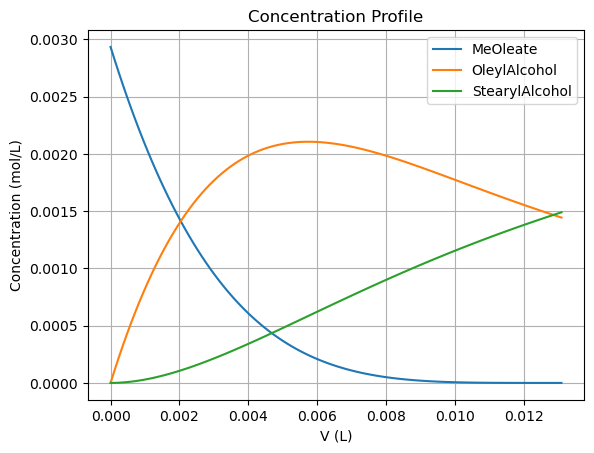

In [10]:
# Ordered components list
components = [
    "MeOleate", "MeElaidate", "MeStearate", "MePalmitate",
    "OleylAlcohol", "ElaidylAlcohol", "StearylAlcohol",
    "CetylAlcohol", "Methanol", "H2_Consumption"
]

# Initial concentrations in [mol/L]
initial_concentrations = {
    "MeOleate": c_MeOleate_0, "MeElaidate": 0.0, "MeStearate": 0.0, "MePalmitate": 0.0,
    "OleylAlcohol": 0.0, "ElaidylAlcohol": 0.0, "StearylAlcohol": 0.0,
    "CetylAlcohol": 0.0, "Methanol": 0.0, "H2_Consumption": 0.0  # Track H2 consumption
}

# Reaction definitions (rate expressions)
def reaction_rates(concentrations):
    """Define the reaction rates based on components concentrations."""
    rates = {
        # Hydrogenolysis
        "r_1": k1 * (p_H2**1.48) * (concentrations["MeOleate"]**0.77) , # [mol/(L min)]
        # Saturation
        "r_2": (k2/60) * (concentrations["OleylAlcohol"]) , # [mol/(L min)]
    }
    return rates

# Define the differential equation system (PFR model)
def pfr_model(V, C): 
    # Unpack concentrations into a dictionary for clarity
    concentrations = {components[i]: C[i] for i in range(len(components))} # [mol/L]
    rates = reaction_rates(concentrations) # [mol/(L min)]
    
    # Differential equations for each component
    dC = {key: 0.0 for key in components}  # Initialize derivatives

    # Define reactions for components
    
    # Hydrogenolysis
    dC["MeOleate"] = -(rates["r_1"]) / Q_l_min # [d(mol/L)/dL  =  (mol/(L min))/(L/min) --> mol/L**2]
    dC["OleylAlcohol"] = (rates["r_1"]-rates["r_2"]) / Q_l_min # [d(mol/L)/dL  =  (mol/(L min))/(L/min) --> mol/L**2]
    
    # Saturation
    dC["StearylAlcohol"] = (rates["r_2"]) / Q_l_min # [d(mol/L)/dL  =  (mol/(L min))/(L/min) --> mol/L**2]
    

    # Convert back to list format for the ODE solver
    return [dC[components[i]] for i in range(len(components))]

# Initial concentrations as a vector
C_0 = [initial_concentrations[sp] for sp in components]

# Set up the integration range (reactor volume)
V_total = 0.120  # Total reactor volume in L
V_range = [0, V_total]  # from V=0 to V_total

# Adjust t_eval to match V_range
t_eval = np.linspace(V_range[0], V_range[1], 1000)  # 100 points between 0 and 0.120

# Solve the ODE system
solution = solve_ivp(
    pfr_model,
    V_range,
    C_0,
    t_eval=t_eval,
    method='RK45'
)

V_points = solution.t  # Reactor volume points [L]

# Specify which components to plot
components_to_plot = ["MeOleate", "OleylAlcohol", "StearylAlcohol"]

# Plot the selected components
for sp in components_to_plot:
    idx = components.index(sp)
    plt.plot(V_points, solution.y[idx], label=sp)

plt.xlabel("V (L)")
plt.ylabel("Concentration (mol/L)")
plt.title("Concentration Profile")
plt.grid(True)
plt.legend()
plt.show()